In [1]:
from init import *

In [2]:
from transformations import (train_transforms,test_transforms,no_transforms)

from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer


# Augmentation
atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)


# No Augmentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=no_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=no_transforms,download=False)
cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

In [3]:
torch.cuda.amp.autocast(enabled=True, dtype=torch.float16, cache_enabled=False)

C:\Users\muthu\Documents\TSAI\session 9\utlis.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


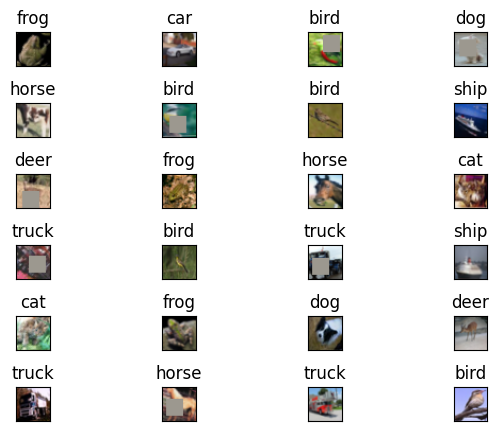

In [4]:
visualize_data(atrain_loader,classes=acifar.classes,num_figures=24)

In [5]:
# visualize_data(train_loader,classes=cifar.classes,num_figures=24)

**small model with augmentation**

In [6]:
dp_rate = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = ConvLayer(inc=3,outc=8,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        
        self.conv2 = ConvLayer(inc=8,outc=24,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep2  = DepthwiseConvLayer(inc=8,outc=24,p=1,s=1,dp_rate=dp_rate)
        self.dil2  = ConvLayer(inc=8,outc=24,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv3 = ConvLayer(inc=24,outc=68,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep3  = DepthwiseConvLayer(inc=24,outc=68,p=1,s=1,dp_rate=dp_rate)
        self.dil3  = ConvLayer(inc=24,outc=68,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.trans4 = TransBlock(100,16,p=0,s=2)


        self.conv_ = ConvLayer(16,32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        
        self.conv5 = ConvLayer(inc=32,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep5  = DepthwiseConvLayer(inc=32,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil5  = ConvLayer(inc=32,outc=48,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv6 = ConvLayer(inc=48,outc=56,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep6  = DepthwiseConvLayer(inc=48,outc=56,p=1,s=1,dp_rate=dp_rate)
        self.dil6  = ConvLayer(inc=48,outc=56,k=3,p=2,s=1,d=2,dp_rate=dp_rate)
      
        self.trans7 = TransBlock(104,16,p=0,s=2)
        self.trans_ = TransBlock(16,16,p=0,s=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = TransBlock(inc=16,outc=10,p=0,s=1)
    
    
    def forward(self,x):        
        x1 = self.conv1(x)
        x2 = self.dep2(x1) + self.conv2(x1) + self.dil2(x1) 
        x3 = self.dep3(x2) + self.conv3(x2) + self.dil3(x2) 
        x4 = torch.concat((x1,x2,x3),dim=1)
        x = self.trans4(x4)

        x = self.conv_(x)
        x5 = self.conv5(x) + self.dep5(x) + self.dil5(x)
        x6 = self.conv6(x5)+ self.dep6(x5)+ self.dil6(x5)
        x7 = torch.concat((x5,x6),dim=1)
        x  = self.trans7(x7)
        x  = self.trans_(x)
        x = self.gap(x)
        x = self.out(x)
        return  F.log_softmax(x.view(-1,10), dim=1)

model = Net().to(device)
summary(model,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─DepthwiseConvLayer: 1-2                [1, 24, 32, 32]           --
│    └─Sequential: 2-2                   [1, 24, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            72
│    │    └─Conv2d: 3-6                  [1, 24, 32, 32]           192
│    │    └─ReLU: 3-7                    [1, 24, 32, 32]           --
│    │    └─BatchNorm2d: 3-8             [1, 24, 32, 32]           48
│    │    └─D

In [7]:
prev_test_loss = float('inf')

if os.path.isfile(r"C:\Users\muthu\Documents\TSAI\session 9\bmodels\model3.pth"): model.load_state_dict(torch.load(r"C:\Users\muthu\Documents\TSAI\session 9\bmodels\model3.pth"))


optimizer = optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 101):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model.state_dict(),f='./bmodels/model3.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.37 | Batch = 97 | Accuracy = 50.86: 100%|███| 98/98 [00:59<00:00,  1.66it/s]


Test set: Average loss: 0.0021, Accuracy: 6218/10000 (62.18%)


EPOCH = 2 | LR = 0.1 | Loss = 1.40 | Batch = 97 | Accuracy = 50.95: 100%|███| 98/98 [00:58<00:00,  1.67it/s]


Test set: Average loss: 0.0021, Accuracy: 6251/10000 (62.51%)


EPOCH = 3 | LR = 0.1 | Loss = 1.24 | Batch = 97 | Accuracy = 51.99: 100%|███| 98/98 [00:59<00:00,  1.65it/s]


Test set: Average loss: 0.0021, Accuracy: 6292/10000 (62.92%)


EPOCH = 4 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 52.27: 100%|███| 98/98 [00:59<00:00,  1.64it/s]


Test set: Average loss: 0.0020, Accuracy: 6384/10000 (63.84%)


EPOCH = 5 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 53.21: 100%|███| 98/98 [00:59<00:00,  1.65it/s]


Test set: Average loss: 0.0020, Accuracy: 6502/10000 (65.02%)


EPOCH = 6 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 53.69: 100%|███| 98/98 [00:59<00:00,  1.63it/s]


Test set: Average loss: 0.0020, Accuracy: 6507/10000 (65.07%)


EPOCH = 7 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 54.40: 100%|███| 98/98 [01:00<00:00,  1.63it/s]


Test set: Average loss: 0.0019, Accuracy: 6679/10000 (66.79%)


EPOCH = 8 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 55.12: 100%|███| 98/98 [00:59<00:00,  1.64it/s]


Test set: Average loss: 0.0020, Accuracy: 6433/10000 (64.33%)


EPOCH = 9 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 55.47: 100%|███| 98/98 [00:59<00:00,  1.64it/s]


Test set: Average loss: 0.0018, Accuracy: 6767/10000 (67.67%)


EPOCH = 10 | LR = 0.1 | Loss = 1.10 | Batch = 97 | Accuracy = 55.75: 100%|██| 98/98 [01:01<00:00,  1.58it/s]


Test set: Average loss: 0.0018, Accuracy: 6743/10000 (67.43%)


EPOCH = 11 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 56.73: 100%|██| 98/98 [00:59<00:00,  1.65it/s]


Test set: Average loss: 0.0019, Accuracy: 6689/10000 (66.89%)


EPOCH = 12 | LR = 0.1 | Loss = 1.15 | Batch = 97 | Accuracy = 56.94: 100%|██| 98/98 [00:59<00:00,  1.64it/s]


Test set: Average loss: 0.0018, Accuracy: 6883/10000 (68.83%)


EPOCH = 13 | LR = 0.1 | Loss = 1.13 | Batch = 97 | Accuracy = 57.28: 100%|██| 98/98 [00:59<00:00,  1.64it/s]


Test set: Average loss: 0.0018, Accuracy: 6882/10000 (68.82%)


EPOCH = 14 | LR = 0.1 | Loss = 1.22 | Batch = 97 | Accuracy = 57.42: 100%|██| 98/98 [01:00<00:00,  1.63it/s]


Test set: Average loss: 0.0018, Accuracy: 6868/10000 (68.68%)


EPOCH = 15 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 57.97: 100%|██| 98/98 [01:00<00:00,  1.63it/s]


Test set: Average loss: 0.0018, Accuracy: 6873/10000 (68.73%)


EPOCH = 16 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 58.03: 100%|██| 98/98 [00:59<00:00,  1.65it/s]


Test set: Average loss: 0.0017, Accuracy: 7058/10000 (70.58%)


EPOCH = 17 | LR = 0.1 | Loss = 1.13 | Batch = 97 | Accuracy = 58.48: 100%|██| 98/98 [00:59<00:00,  1.65it/s]


Test set: Average loss: 0.0017, Accuracy: 7023/10000 (70.23%)


EPOCH = 18 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 59.28: 100%|██| 98/98 [00:59<00:00,  1.65it/s]


Test set: Average loss: 0.0017, Accuracy: 7073/10000 (70.73%)


EPOCH = 19 | LR = 0.1 | Loss = 1.14 | Batch = 97 | Accuracy = 59.21: 100%|██| 98/98 [39:52<00:00, 24.42s/it]


Test set: Average loss: 0.0016, Accuracy: 7080/10000 (70.80%)


EPOCH = 20 | LR = 0.1 | Loss = 1.16 | Batch = 97 | Accuracy = 59.69: 100%|██| 98/98 [01:01<00:00,  1.59it/s]


Test set: Average loss: 0.0017, Accuracy: 7015/10000 (70.15%)


EPOCH = 21 | LR = 0.1 | Loss = 1.16 | Batch = 97 | Accuracy = 59.97: 100%|██| 98/98 [00:59<00:00,  1.64it/s]


Test set: Average loss: 0.0016, Accuracy: 7117/10000 (71.17%)


EPOCH = 22 | LR = 0.1 | Loss = 1.06 | Batch = 97 | Accuracy = 60.57: 100%|██| 98/98 [00:59<00:00,  1.65it/s]


Test set: Average loss: 0.0016, Accuracy: 7143/10000 (71.43%)


EPOCH = 23 | LR = 0.1 | Loss = 1.10 | Batch = 97 | Accuracy = 60.69: 100%|██| 98/98 [01:00<00:00,  1.61it/s]


Test set: Average loss: 0.0016, Accuracy: 7179/10000 (71.79%)


EPOCH = 24 | LR = 0.1 | Loss = 1.15 | Batch = 97 | Accuracy = 60.68: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0016, Accuracy: 7228/10000 (72.28%)


EPOCH = 25 | LR = 0.1 | Loss = 1.10 | Batch = 97 | Accuracy = 60.92: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0016, Accuracy: 7096/10000 (70.96%)


EPOCH = 26 | LR = 0.1 | Loss = 1.04 | Batch = 97 | Accuracy = 61.58: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0015, Accuracy: 7283/10000 (72.83%)


EPOCH = 27 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 61.52: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0015, Accuracy: 7386/10000 (73.86%)


EPOCH = 28 | LR = 0.1 | Loss = 1.05 | Batch = 97 | Accuracy = 61.90: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0016, Accuracy: 7246/10000 (72.46%)


EPOCH = 29 | LR = 0.1 | Loss = 1.01 | Batch = 97 | Accuracy = 61.93: 100%|██| 98/98 [01:00<00:00,  1.61it/s]


Test set: Average loss: 0.0015, Accuracy: 7486/10000 (74.86%)


EPOCH = 30 | LR = 0.1 | Loss = 1.22 | Batch = 97 | Accuracy = 62.02: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0015, Accuracy: 7428/10000 (74.28%)


EPOCH = 31 | LR = 0.1 | Loss = 1.14 | Batch = 97 | Accuracy = 62.30: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0015, Accuracy: 7354/10000 (73.54%)


EPOCH = 32 | LR = 0.1 | Loss = 1.05 | Batch = 97 | Accuracy = 62.56: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0015, Accuracy: 7449/10000 (74.49%)


EPOCH = 33 | LR = 0.1 | Loss = 1.10 | Batch = 97 | Accuracy = 62.96: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0015, Accuracy: 7502/10000 (75.02%)


EPOCH = 34 | LR = 0.1 | Loss = 1.02 | Batch = 97 | Accuracy = 62.87: 100%|██| 98/98 [01:00<00:00,  1.61it/s]


Test set: Average loss: 0.0015, Accuracy: 7503/10000 (75.03%)


EPOCH = 35 | LR = 0.1 | Loss = 0.89 | Batch = 97 | Accuracy = 62.98: 100%|██| 98/98 [01:01<00:00,  1.61it/s]


Test set: Average loss: 0.0015, Accuracy: 7452/10000 (74.52%)


EPOCH = 36 | LR = 0.1 | Loss = 1.00 | Batch = 97 | Accuracy = 63.33: 100%|██| 98/98 [01:01<00:00,  1.61it/s]


Test set: Average loss: 0.0014, Accuracy: 7511/10000 (75.11%)


EPOCH = 37 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 63.13: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0014, Accuracy: 7582/10000 (75.82%)


EPOCH = 38 | LR = 0.1 | Loss = 0.98 | Batch = 97 | Accuracy = 63.03: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0014, Accuracy: 7662/10000 (76.62%)


EPOCH = 39 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 63.56: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0014, Accuracy: 7559/10000 (75.59%)


EPOCH = 40 | LR = 0.1 | Loss = 1.22 | Batch = 97 | Accuracy = 63.75: 100%|██| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0014, Accuracy: 7516/10000 (75.16%)


EPOCH = 41 | LR = 0.1 | Loss = 1.08 | Batch = 97 | Accuracy = 63.34: 100%|██| 98/98 [01:02<00:00,  1.58it/s]


Test set: Average loss: 0.0014, Accuracy: 7585/10000 (75.85%)


EPOCH = 42 | LR = 0.1 | Loss = 1.05 | Batch = 97 | Accuracy = 63.79: 100%|██| 98/98 [01:02<00:00,  1.58it/s]


Test set: Average loss: 0.0014, Accuracy: 7605/10000 (76.05%)


EPOCH = 43 | LR = 0.1 | Loss = 0.99 | Batch = 97 | Accuracy = 64.03: 100%|██| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0013, Accuracy: 7702/10000 (77.02%)


EPOCH = 44 | LR = 0.1 | Loss = 1.06 | Batch = 97 | Accuracy = 64.33: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0013, Accuracy: 7622/10000 (76.22%)


EPOCH = 45 | LR = 0.1 | Loss = 1.02 | Batch = 97 | Accuracy = 64.31: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0014, Accuracy: 7673/10000 (76.73%)


EPOCH = 46 | LR = 0.1 | Loss = 1.06 | Batch = 97 | Accuracy = 64.28: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0014, Accuracy: 7540/10000 (75.40%)


EPOCH = 47 | LR = 0.1 | Loss = 1.13 | Batch = 97 | Accuracy = 64.01: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0013, Accuracy: 7727/10000 (77.27%)


EPOCH = 48 | LR = 0.010000000000000002 | Loss = 0.90 | Batch = 97 | Accuracy = 65.68: 100%|█| 98/98 [00:46<0


Test set: Average loss: 0.0013, Accuracy: 7798/10000 (77.98%)


EPOCH = 49 | LR = 0.010000000000000002 | Loss = 1.06 | Batch = 97 | Accuracy = 66.16: 100%|█| 98/98 [00:46<0


Test set: Average loss: 0.0013, Accuracy: 7844/10000 (78.44%)


EPOCH = 50 | LR = 0.010000000000000002 | Loss = 0.96 | Batch = 97 | Accuracy = 66.46: 100%|█| 98/98 [00:46<0


Test set: Average loss: 0.0013, Accuracy: 7852/10000 (78.52%)


EPOCH = 51 | LR = 0.010000000000000002 | Loss = 0.96 | Batch = 97 | Accuracy = 66.70: 100%|█| 98/98 [00:46<0


Test set: Average loss: 0.0012, Accuracy: 7900/10000 (79.00%)


EPOCH = 52 | LR = 0.010000000000000002 | Loss = 0.93 | Batch = 97 | Accuracy = 66.94: 100%|█| 98/98 [00:47<0


Test set: Average loss: 0.0013, Accuracy: 7871/10000 (78.71%)


EPOCH = 53 | LR = 0.010000000000000002 | Loss = 0.94 | Batch = 97 | Accuracy = 66.91: 100%|█| 98/98 [00:48<0


Test set: Average loss: 0.0012, Accuracy: 7879/10000 (78.79%)


EPOCH = 54 | LR = 0.010000000000000002 | Loss = 0.94 | Batch = 97 | Accuracy = 66.76: 100%|█| 98/98 [00:47<0


Test set: Average loss: 0.0013, Accuracy: 7876/10000 (78.76%)


EPOCH = 55 | LR = 0.010000000000000002 | Loss = 0.81 | Batch = 97 | Accuracy = 66.85: 100%|█| 98/98 [00:47<0


Test set: Average loss: 0.0013, Accuracy: 7812/10000 (78.12%)


EPOCH = 56 | LR = 0.010000000000000002 | Loss = 0.86 | Batch = 97 | Accuracy = 66.87: 100%|█| 98/98 [00:47<0


Test set: Average loss: 0.0012, Accuracy: 7894/10000 (78.94%)


EPOCH = 57 | LR = 0.010000000000000002 | Loss = 0.95 | Batch = 97 | Accuracy = 67.12: 100%|█| 98/98 [00:47<0


Test set: Average loss: 0.0012, Accuracy: 7877/10000 (78.77%)


EPOCH = 58 | LR = 0.010000000000000002 | Loss = 0.91 | Batch = 97 | Accuracy = 67.04: 100%|█| 98/98 [00:47<0


Test set: Average loss: 0.0012, Accuracy: 7896/10000 (78.96%)


EPOCH = 59 | LR = 0.010000000000000002 | Loss = 0.95 | Batch = 97 | Accuracy = 66.81: 100%|█| 98/98 [00:47<0


Test set: Average loss: 0.0012, Accuracy: 7879/10000 (78.79%)


EPOCH = 60 | LR = 0.010000000000000002 | Loss = 0.98 | Batch = 97 | Accuracy = 67.25: 100%|█| 98/98 [00:47<0


Test set: Average loss: 0.0012, Accuracy: 7868/10000 (78.68%)


EPOCH = 61 | LR = 0.0010000000000000002 | Loss = 0.89 | Batch = 97 | Accuracy = 66.99: 100%|█| 98/98 [00:47<


Test set: Average loss: 0.0012, Accuracy: 7891/10000 (78.91%)


EPOCH = 62 | LR = 0.0010000000000000002 | Loss = 0.88 | Batch = 97 | Accuracy = 67.06: 100%|█| 98/98 [00:47<


Test set: Average loss: 0.0012, Accuracy: 7873/10000 (78.73%)


EPOCH = 63 | LR = 0.0010000000000000002 | Loss = 0.92 | Batch = 97 | Accuracy = 67.42: 100%|█| 98/98 [00:47<


Test set: Average loss: 0.0012, Accuracy: 7901/10000 (79.01%)


EPOCH = 64 | LR = 0.0010000000000000002 | Loss = 0.84 | Batch = 97 | Accuracy = 67.05: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7902/10000 (79.02%)


EPOCH = 65 | LR = 0.0010000000000000002 | Loss = 0.85 | Batch = 97 | Accuracy = 67.24: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7901/10000 (79.01%)


EPOCH = 66 | LR = 0.0010000000000000002 | Loss = 0.91 | Batch = 97 | Accuracy = 67.34: 100%|█| 98/98 [00:46<


Test set: Average loss: 0.0012, Accuracy: 7897/10000 (78.97%)


EPOCH = 67 | LR = 0.0010000000000000002 | Loss = 1.02 | Batch = 97 | Accuracy = 66.96: 100%|█| 98/98 [00:46<


Test set: Average loss: 0.0012, Accuracy: 7890/10000 (78.90%)


EPOCH = 68 | LR = 0.0010000000000000002 | Loss = 0.90 | Batch = 97 | Accuracy = 67.34: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7900/10000 (79.00%)


EPOCH = 69 | LR = 0.0010000000000000002 | Loss = 0.97 | Batch = 97 | Accuracy = 67.11: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7894/10000 (78.94%)


EPOCH = 70 | LR = 0.0010000000000000002 | Loss = 0.95 | Batch = 97 | Accuracy = 67.50: 100%|█| 98/98 [00:46<


Test set: Average loss: 0.0012, Accuracy: 7898/10000 (78.98%)


EPOCH = 71 | LR = 0.0010000000000000002 | Loss = 0.86 | Batch = 97 | Accuracy = 67.37: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7899/10000 (78.99%)


EPOCH = 72 | LR = 0.0010000000000000002 | Loss = 0.91 | Batch = 97 | Accuracy = 67.31: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7889/10000 (78.89%)


EPOCH = 73 | LR = 0.00010000000000000003 | Loss = 0.94 | Batch = 97 | Accuracy = 67.40: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7881/10000 (78.81%)


EPOCH = 74 | LR = 0.00010000000000000003 | Loss = 0.96 | Batch = 97 | Accuracy = 67.20: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7897/10000 (78.97%)


EPOCH = 75 | LR = 0.00010000000000000003 | Loss = 0.95 | Batch = 97 | Accuracy = 67.22: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7911/10000 (79.11%)


EPOCH = 76 | LR = 0.00010000000000000003 | Loss = 0.89 | Batch = 97 | Accuracy = 67.26: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7886/10000 (78.86%)


EPOCH = 77 | LR = 1.0000000000000004e-05 | Loss = 0.93 | Batch = 97 | Accuracy = 66.85: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7892/10000 (78.92%)


EPOCH = 78 | LR = 1.0000000000000004e-05 | Loss = 0.88 | Batch = 97 | Accuracy = 67.30: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7886/10000 (78.86%)


EPOCH = 79 | LR = 1.0000000000000004e-05 | Loss = 0.94 | Batch = 97 | Accuracy = 67.74: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7896/10000 (78.96%)


EPOCH = 80 | LR = 1.0000000000000004e-05 | Loss = 1.11 | Batch = 97 | Accuracy = 67.22: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7891/10000 (78.91%)


EPOCH = 81 | LR = 1.0000000000000004e-06 | Loss = 0.84 | Batch = 97 | Accuracy = 67.30: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7899/10000 (78.99%)


EPOCH = 82 | LR = 1.0000000000000004e-06 | Loss = 0.93 | Batch = 97 | Accuracy = 67.07: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7883/10000 (78.83%)


EPOCH = 83 | LR = 1.0000000000000004e-06 | Loss = 0.89 | Batch = 97 | Accuracy = 67.58: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7897/10000 (78.97%)


EPOCH = 84 | LR = 1.0000000000000004e-06 | Loss = 0.87 | Batch = 97 | Accuracy = 67.37: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7892/10000 (78.92%)


EPOCH = 85 | LR = 1.0000000000000005e-07 | Loss = 0.91 | Batch = 97 | Accuracy = 67.39: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7895/10000 (78.95%)


EPOCH = 86 | LR = 1.0000000000000005e-07 | Loss = 1.00 | Batch = 97 | Accuracy = 67.43: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7889/10000 (78.89%)


EPOCH = 87 | LR = 1.0000000000000005e-07 | Loss = 0.90 | Batch = 97 | Accuracy = 67.41: 100%|█| 98/98 [00:47


Test set: Average loss: 0.0012, Accuracy: 7891/10000 (78.91%)


EPOCH = 88 | LR = 1.0000000000000005e-07 | Loss = 0.95 | Batch = 97 | Accuracy = 67.17: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7893/10000 (78.93%)


EPOCH = 89 | LR = 1.0000000000000005e-08 | Loss = 0.92 | Batch = 97 | Accuracy = 67.25: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7891/10000 (78.91%)


EPOCH = 90 | LR = 1.0000000000000005e-08 | Loss = 0.91 | Batch = 97 | Accuracy = 67.31: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7887/10000 (78.87%)


EPOCH = 91 | LR = 1.0000000000000005e-08 | Loss = 0.97 | Batch = 97 | Accuracy = 67.25: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7894/10000 (78.94%)


EPOCH = 92 | LR = 1.0000000000000005e-08 | Loss = 0.88 | Batch = 97 | Accuracy = 67.49: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7903/10000 (79.03%)


EPOCH = 93 | LR = 1.0000000000000005e-08 | Loss = 0.82 | Batch = 97 | Accuracy = 67.36: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7891/10000 (78.91%)


EPOCH = 94 | LR = 1.0000000000000005e-08 | Loss = 0.88 | Batch = 97 | Accuracy = 67.02: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7885/10000 (78.85%)


EPOCH = 95 | LR = 1.0000000000000005e-08 | Loss = 0.93 | Batch = 97 | Accuracy = 67.29: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7897/10000 (78.97%)


EPOCH = 96 | LR = 1.0000000000000005e-08 | Loss = 0.92 | Batch = 97 | Accuracy = 67.42: 100%|█| 98/98 [00:47


Test set: Average loss: 0.0012, Accuracy: 7897/10000 (78.97%)


EPOCH = 97 | LR = 1.0000000000000005e-08 | Loss = 0.93 | Batch = 97 | Accuracy = 67.42: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7896/10000 (78.96%)


EPOCH = 98 | LR = 1.0000000000000005e-08 | Loss = 1.01 | Batch = 97 | Accuracy = 67.42: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7891/10000 (78.91%)


EPOCH = 99 | LR = 1.0000000000000005e-08 | Loss = 0.97 | Batch = 97 | Accuracy = 67.36: 100%|█| 98/98 [00:47


Test set: Average loss: 0.0012, Accuracy: 7885/10000 (78.85%)


EPOCH = 100 | LR = 1.0000000000000005e-08 | Loss = 0.95 | Batch = 97 | Accuracy = 67.41: 100%|█| 98/98 [00:4


Test set: Average loss: 0.0012, Accuracy: 7891/10000 (78.91%)


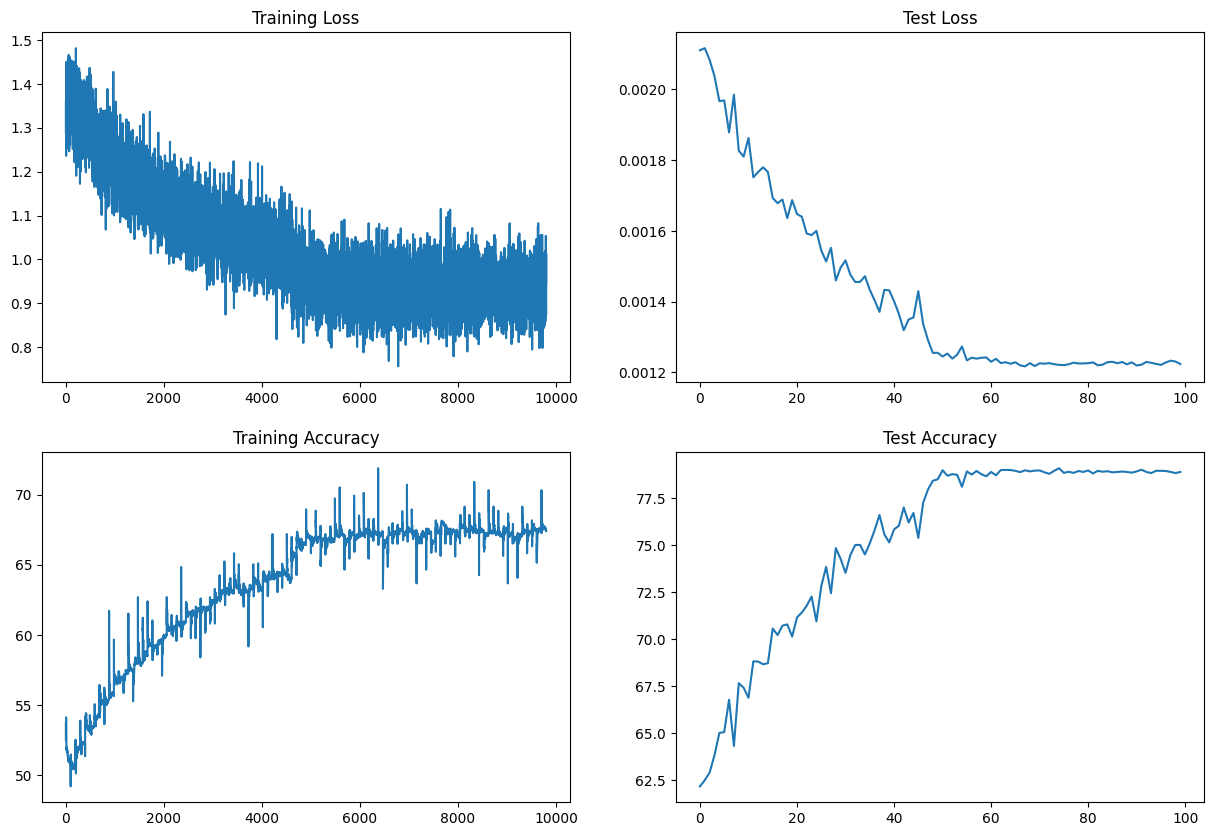

In [8]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

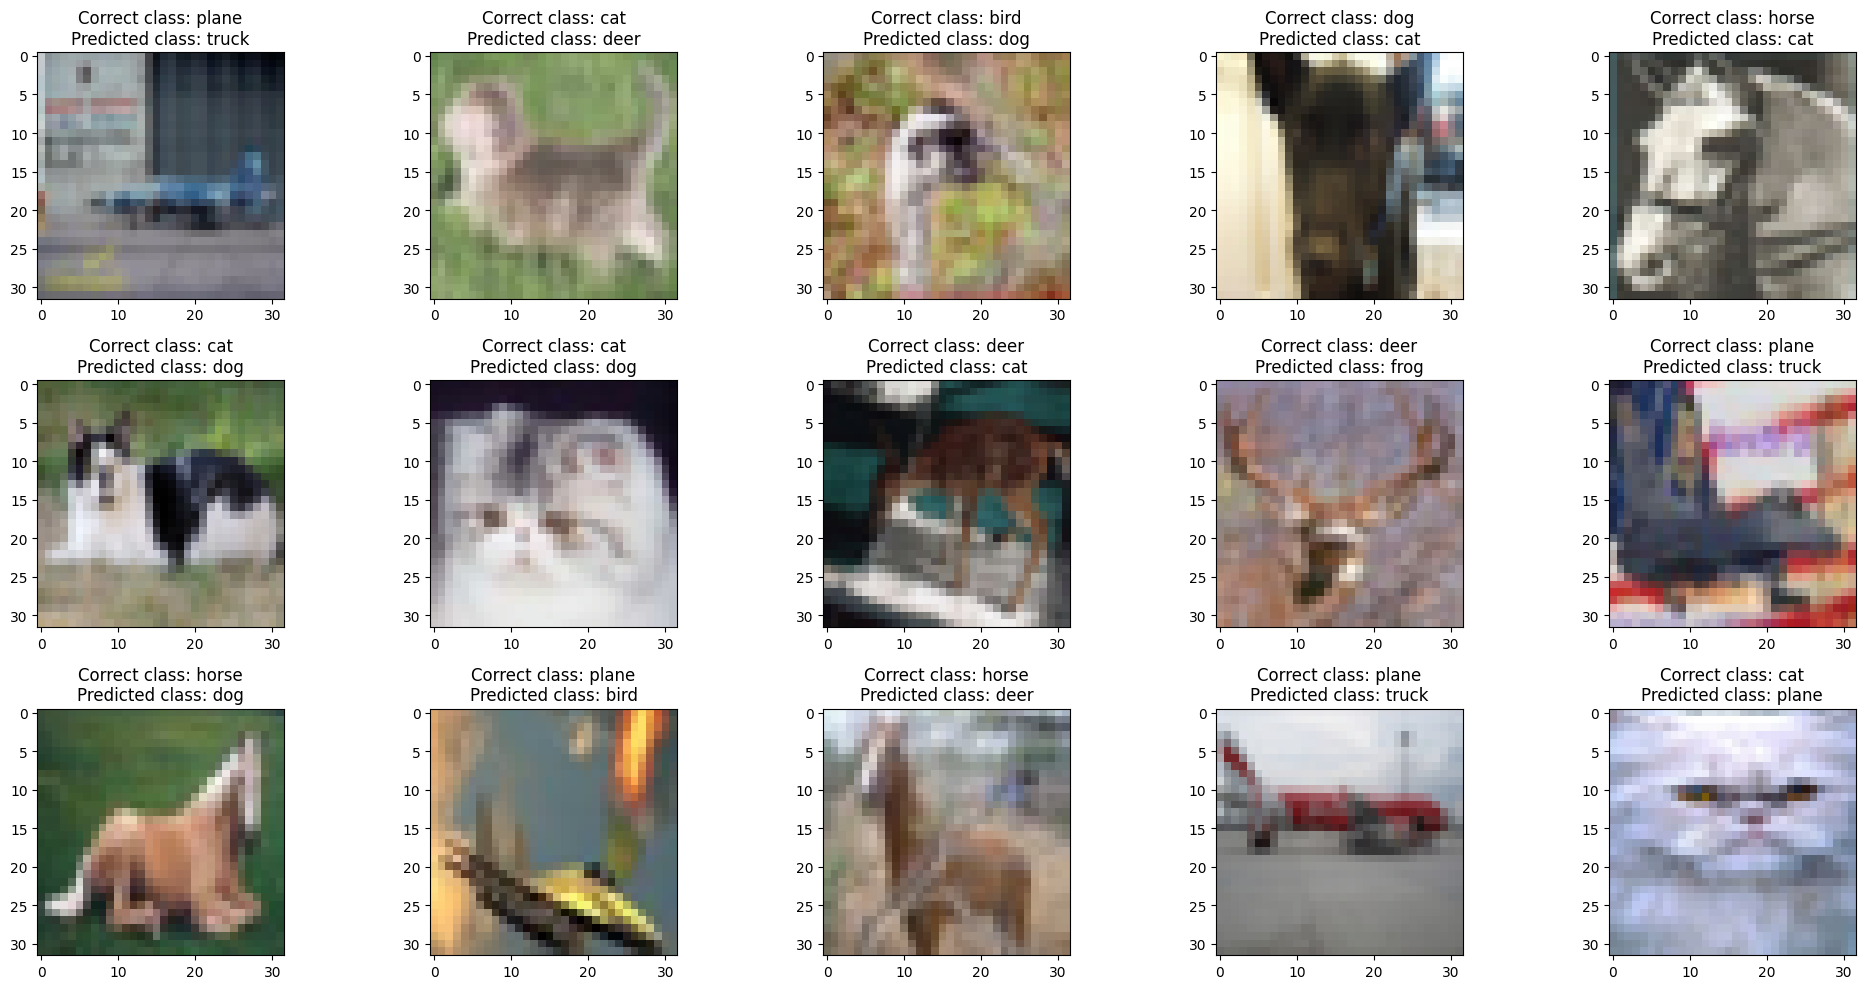

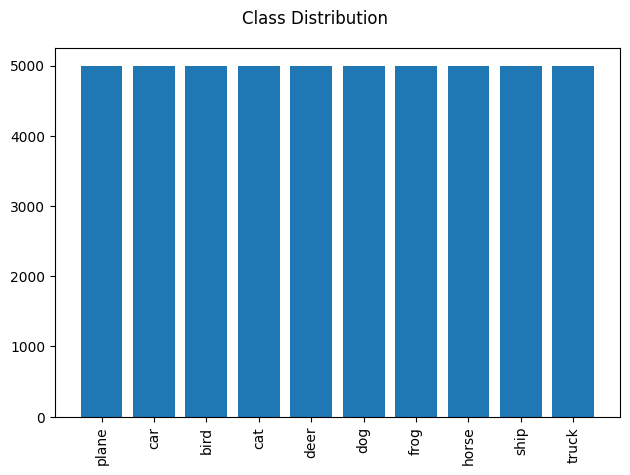

In [10]:
images, predictions, labels =  tester.get_misclassified_images()
show_misclassified_images(images[:15],predictions[:15],labels[:15],cifar.classes)
plot_class_distribution(train_loader,cifar.classes)

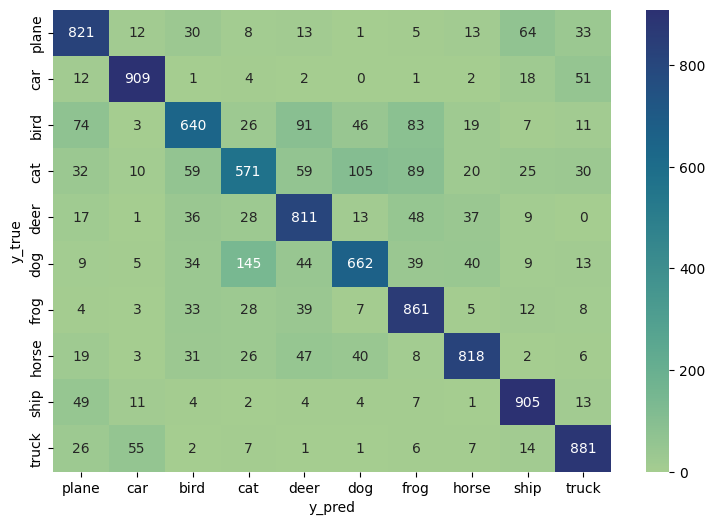

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
def plot_confusion_matrix(model,test_loader,device,classes):
    model.eval()
    predictions = []
    labels = []  # TRUTH
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.permute(0,3,1,2))
            _, preds = torch.max(output, 1)
            predictions.extend(preds.cpu().numpy())
            labels.extend(target.cpu().numpy())
    
    cm= confusion_matrix(y_true= [i.item() for i in labels],y_pred=[i.item() for i in predictions])
    columns ={}
    for i,v in enumerate(classes):
        columns[i]=v
    plt.figure(figsize=(9,6))
    sns.heatmap(pd.DataFrame(cm).rename(columns=columns,index=columns),annot=True,fmt='',cmap="crest")
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    plt.show()




plot_confusion_matrix(model,test_loader,device,cifar.classes)

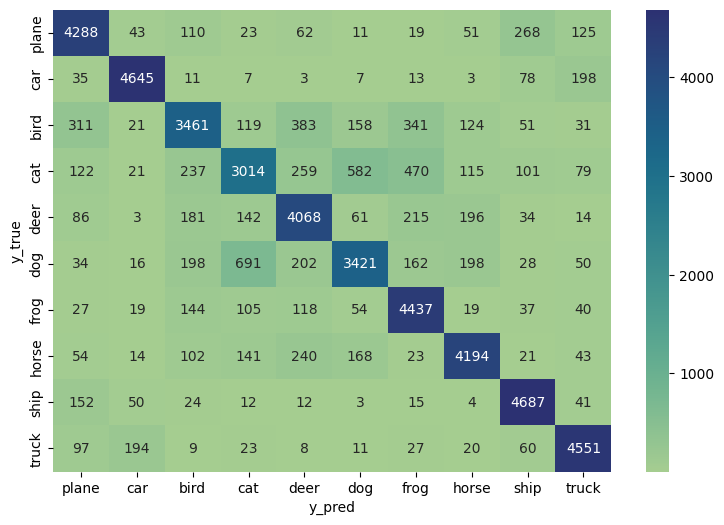

In [17]:
plot_confusion_matrix(model,train_loader,device,cifar.classes)